In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('..')
import pandas as pd
from model import VAE, plus_encode_data
import seaborn as sns
from sklearn.mixture import GaussianMixture
import joblib
import input_pipeline
from sklearn.manifold import TSNE

2024-04-16 12:32:57.984822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Gaussian mixture fitting

In [2]:
def load_model_at_T(t, folder,  latent_dim = 200):
    model = VAE(latent_dim)
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights(f'{folder}/{t:.1f}/vae{t:.1f}.h5')
    return model

In [ ]:
temps = np.arange(2.0, 3.0, 0.1)
folder = "Results/vae2"
titles = [f"Temperature: {t:.1}" for t in temps]
models = {t: load_model_at_T(t, folder) for t in temps}

In [6]:
gm_vars = GaussianMixture(n_components=2, random_state=0)
gm_means = GaussianMixture(n_components=1, random_state=0)

for temp in temps:
    model = models[temp]
    batch_size = 100
    
    trainset_path = f"../../GetData/Python/Data/Data{temp:.1}.tfrecord"
    train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)

    # data mc trainset
    data_var = []
    data_mean = []
    for batch in train_set:
        data_mc = batch
        data_plus = plus_encode_data(data_mc)
        mean, var = model.encode(data_plus)
        data_var.append(var)
        data_mean.append(mean)
    
    vars = np.concatenate(data_var, axis=0)
    means = np.concatenate(data_mean, axis=0)

    gm_vars.fit(vars)
    gm_means.fit(means)

    # Save the GMM models
    joblib.dump(gm_vars, f"{folder}/{temp:.1f}/gm_vars.pkl")
    joblib.dump(gm_means, f"{folder}/{temp:.1f}/gm_means.pkl")
    
    print(f"Temperature: {temp:.1}")

Temperature: 2.0
Temperature: 2.1
Temperature: 2.2
Temperature: 2.3
Temperature: 2.4
Temperature: 2.5
Temperature: 2.6
Temperature: 2.7
Temperature: 2.8
Temperature: 2.9


# Tsne

In [ ]:
temp = 2.3
model = models[temp]
batch_size = 100

trainset_path = f"../../GetData/Python/Data/Data{temp:.1}.tfrecord"
train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)

# data mc trainset
data_var = []
data_mean = []
for batch in train_set:
    data_mc = batch
    data_plus = plus_encode_data(data_mc)
    mean, var = model.encode(data_plus)
    data_var.append(var)
    data_mean.append(mean)

vars = np.concatenate(data_var, axis=0)
means = np.concatenate(data_mean, axis=0)

In [33]:
tsne_mean = TSNE(n_components=2, perplexity=50, n_iter=10000, verbose=1, random_state=123)
v = tsne_mean.fit_transform(means) 

df_mean = pd.DataFrame()
df_mean["x"] = v[:,0]
df_mean["y"] = v[:,1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.449s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.466892
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.805122
[t-SNE] KL divergence after 4950 iterations: 4.020866


<Axes: xlabel='x', ylabel='y'>

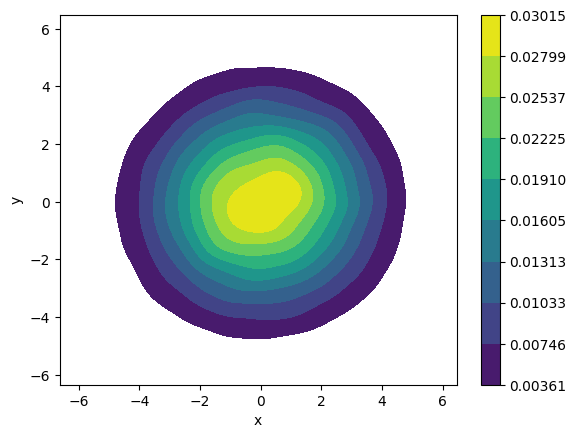

In [34]:
sns.kdeplot(data=df_mean, x='x', y='y', cmap='viridis', fill=True, cbar=True)

In [35]:
tsne_var = TSNE(n_components=2, perplexity=50, n_iter=10000, verbose=1, random_state=123)
v = tsne_var.fit_transform(vars) 
df_var = pd.DataFrame()
df_var["x"] = v[:,0]
df_var["y"] = v[:,1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.208300
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.914848
[t-SNE] KL divergence after 10000 iterations: 3.141727


<Axes: xlabel='x', ylabel='y'>

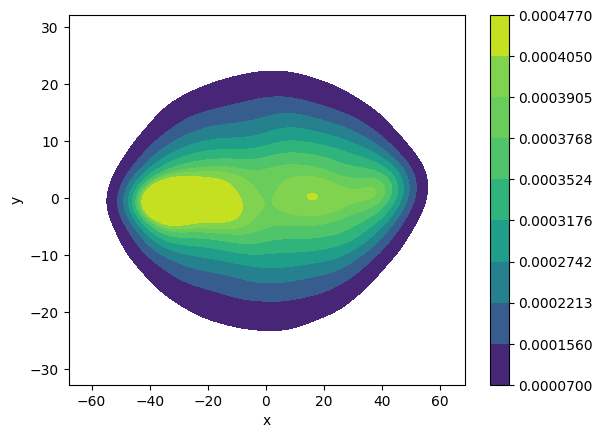

In [36]:
sns.kdeplot(data=df_var, x='x', y='y', cmap='viridis', fill=True, cbar=True)